### To analyze repeated experiment data for repeatability

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# Load datasets
data1 = pd.read_csv('experiment_data/P-FL_OD_run_data_042325.csv')
data2 = pd.read_csv('experiment_data/P-FL_OD_run_data_040625.csv')

# Setpoints 
st_pt_1 = 11500
st_pt_2 = 18500

In [3]:
# Only extract P-control wells
# P_control_wells = ['B9', 'C9', 'D9', 'E9', 'F9', 'G9']

P1_data1 = data1[['SP1_1',  'SP1_2',  'SP1_3', 'SP1_4', 'SP1_5', 'SP1_6']].to_numpy()
P2_data1 = data1[['SP2_1',  'SP2_2',  'SP2_3', 'SP2_4', 'SP2_5', 'SP2_6']].to_numpy()

P1_data2 = data2[['SP1_1',  'SP1_2',  'SP1_3']].to_numpy()
P2_data2 = data2[['SP2_1',  'SP2_2',  'SP2_3']].to_numpy()

# Extract Green/Red constants (with replicates for 040825)
red_data1 = data1[['R1']].to_numpy()
green_data1 = data1[['G1']].to_numpy()

# For 0401025, Green and Red have only 1 well each
green_data2 = data2[['G1',  'G2', 'G3']].to_numpy()
red_data2 = data2[['R1',  'R2',  'R3']].to_numpy()

In [4]:
def smooth_signal_lowess(signal, time, frac=0.05):
    """
    Apply LOWESS smoothing.
    
    Parameters:
    - signal: 1D array of data
    - time: 1D array of time points
    - frac: Fraction of data used when estimating each y-value
    
    Returns:
    - smoothed signal as 1D numpy array
    """
    smoothed = lowess(signal, time, frac=frac, return_sorted=False)
    return smoothed

In [5]:
# Automatically find the smaller length
min_length = min(P1_data1.shape[0], P1_data2.shape[0])

# Truncate everything to min_length
P1_data1 = P1_data1[:min_length, :]
P1_data2 = P1_data2[:min_length, :]
P2_data1 = P2_data1[:min_length, :]
P2_data2 = P2_data2[:min_length, :]

green_data1 = green_data1[:min_length, :]
green_data2 = green_data2[:min_length, :]
red_data1 = red_data1[:min_length, :]
red_data2 = red_data2[:min_length, :]

In [6]:
# Define separate time vectors for each dataset
interval = 10  # minutes

N_size1 = min_length  # 040825
N_size2 = min_length # 0401025

time1 = np.arange(interval, (N_size1 + 1) * interval, interval)
time2 = np.arange(interval, (N_size2 + 1) * interval, interval)

xlimit = 16 * 60  # 16 hours

# Define color dictionary
color_dict = {
    'set_point_1': '#6759d4', 
    'set_point_2': '#ebab4b',
    'green_constant': 'green',
    'red_constant': 'red'
}

In [7]:
# Fraction of data points to use in the smoothing window
frac_value = 0.05

# Apply LOWESS smoothing to each column (replicate) for each dataset
P1_data1_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time1, frac=frac_value), 0, P1_data1)
P2_data1_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time1, frac=frac_value), 0, P2_data1)

P1_data2_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time2, frac=frac_value), 0, P1_data2)
P2_data2_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time2, frac=frac_value), 0, P2_data2)

green_data1_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time1, frac=frac_value), 0, green_data1)
green_data2_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time2, frac=frac_value), 0, green_data2)
red_data1_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time1, frac=frac_value), 0, red_data1)
red_data2_smooth = np.apply_along_axis(lambda x: smooth_signal_lowess(x, time2, frac=frac_value), 0, red_data2)

# Replace with smoothed data
P1_data1, P2_data1 = P1_data1_smooth, P2_data1_smooth
P1_data2, P2_data2 = P1_data2_smooth, P2_data2_smooth
green_data1, green_data2 = green_data1_smooth, green_data2_smooth
red_data1, red_data2 = red_data1_smooth, red_data2_smooth

In [8]:
# Combine datasets
P1_combined = np.hstack([P1_data1, P1_data2])
P2_combined = np.hstack([P2_data1, P2_data2])

green_combined = np.hstack([green_data1, green_data2])
red_combined = np.hstack([red_data1, red_data2])

# Compute average and std deviation
P1_mean = np.mean(P1_combined, axis=1)
P1_std = np.std(P1_combined, axis=1)

P2_mean = np.mean(P2_combined, axis=1)
P2_std = np.std(P2_combined, axis=1)

green_mean = np.mean(green_combined, axis=1)
green_std = np.std(green_combined, axis=1)

red_mean = np.mean(red_combined, axis=1)
red_std = np.std(red_combined, axis=1)

# to plot the tolerence band
tolerance_band = 0.1 * (np.max(green_mean - red_mean)) # 5% of the maximum dynamic range

In [9]:
# Helper function to plot individual replicates
def plot_replicates(time, P1, P2, green, red, title):
    fig, ax = plt.subplots(figsize=(8,5), dpi=300)
    
    for i in range(P1.shape[1]):
        ax.plot(time, P1[:, i], color=color_dict['set_point_1'], label=f'Set Pt 1 (N =' + str(P1.shape[1]) + ')' if i==0 else None)
        
    for i in range(P2.shape[1]):
        ax.plot(time, P2[:, i], color=color_dict['set_point_2'], label=f'Set Pt 2 (N =' + str(P2.shape[1]) + ')' if i==0 else None)
    
    for i in range(green.shape[1]):
        ax.plot(time, green[:, i], color=color_dict['green_constant'], linestyle='--', label=f'Green (N =' + str(green.shape[1]) + ')' if i==0 else None)
    
    for i in range(red.shape[1]):
        ax.plot(time, red[:, i], color=color_dict['red_constant'], linestyle='--', label=f'Red (N =' + str(red.shape[1]) + ')' if i==0 else None)
    
    # Draw tolerence bands
    upper_1 = st_pt_1 + tolerance_band
    lower_1 = st_pt_1 - tolerance_band
    ax.axhline(upper_1, color=color_dict['set_point_1'], alpha=0.5, linewidth=1)
    ax.axhline(lower_1, color=color_dict['set_point_1'], alpha=0.5, linewidth=1)
    ax.fill_between(time, lower_1, upper_1, color=color_dict['set_point_1'], alpha=0.05)

    upper_2 = st_pt_2 + tolerance_band
    lower_2 = st_pt_2 - tolerance_band
    ax.axhline(upper_2, color=color_dict['set_point_2'], alpha=0.5, linewidth=1)
    ax.axhline(lower_2, color=color_dict['set_point_2'], alpha=0.5, linewidth=1)
    ax.fill_between(time, lower_2, upper_2, color=color_dict['set_point_2'], alpha=0.05)
    
    # Draw horizontal lines at correct setpoints
    ax.axhline(y=st_pt_1, color=color_dict['set_point_1'])
    ax.axhline(y=st_pt_2, color=color_dict['set_point_2'])

    ax.set_xlabel('Time (min)', fontsize=14)
    ax.set_ylabel('FL/OD (a.u.)', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc = 'best')
    ax.grid(True)
    ax.set_xlim((0, xlimit))
    plt.show()

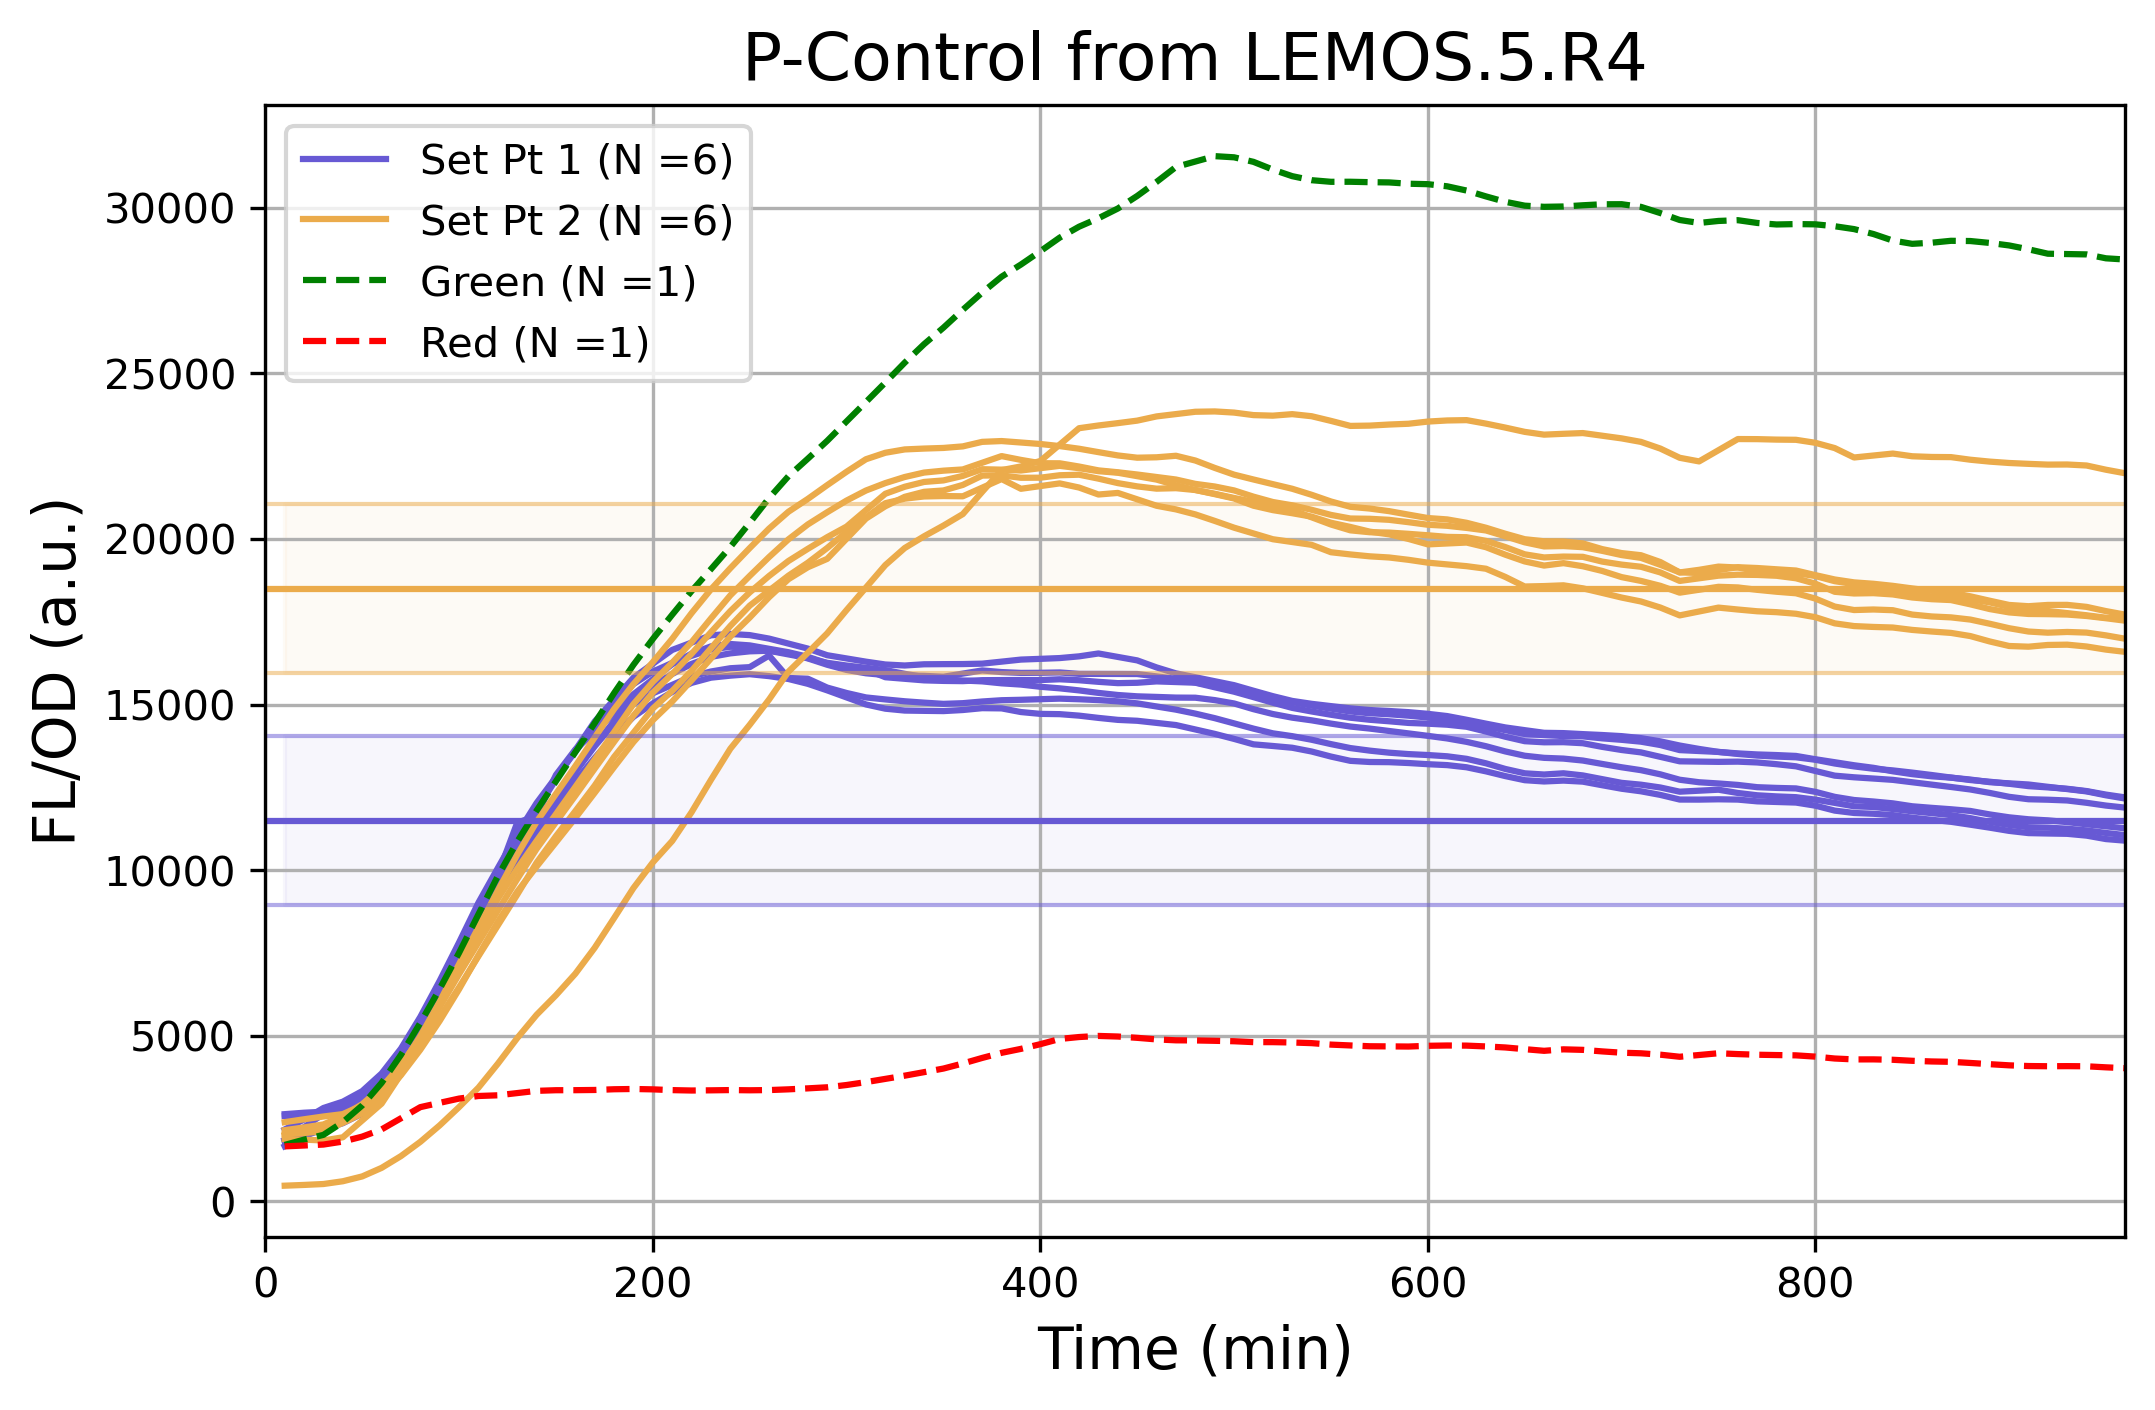

In [10]:
# Figure 1: Dataset 040825
plot_replicates(time1, P1_data1, P2_data1, green_data1, red_data1, 'P-Control from LEMOS.5.R4')

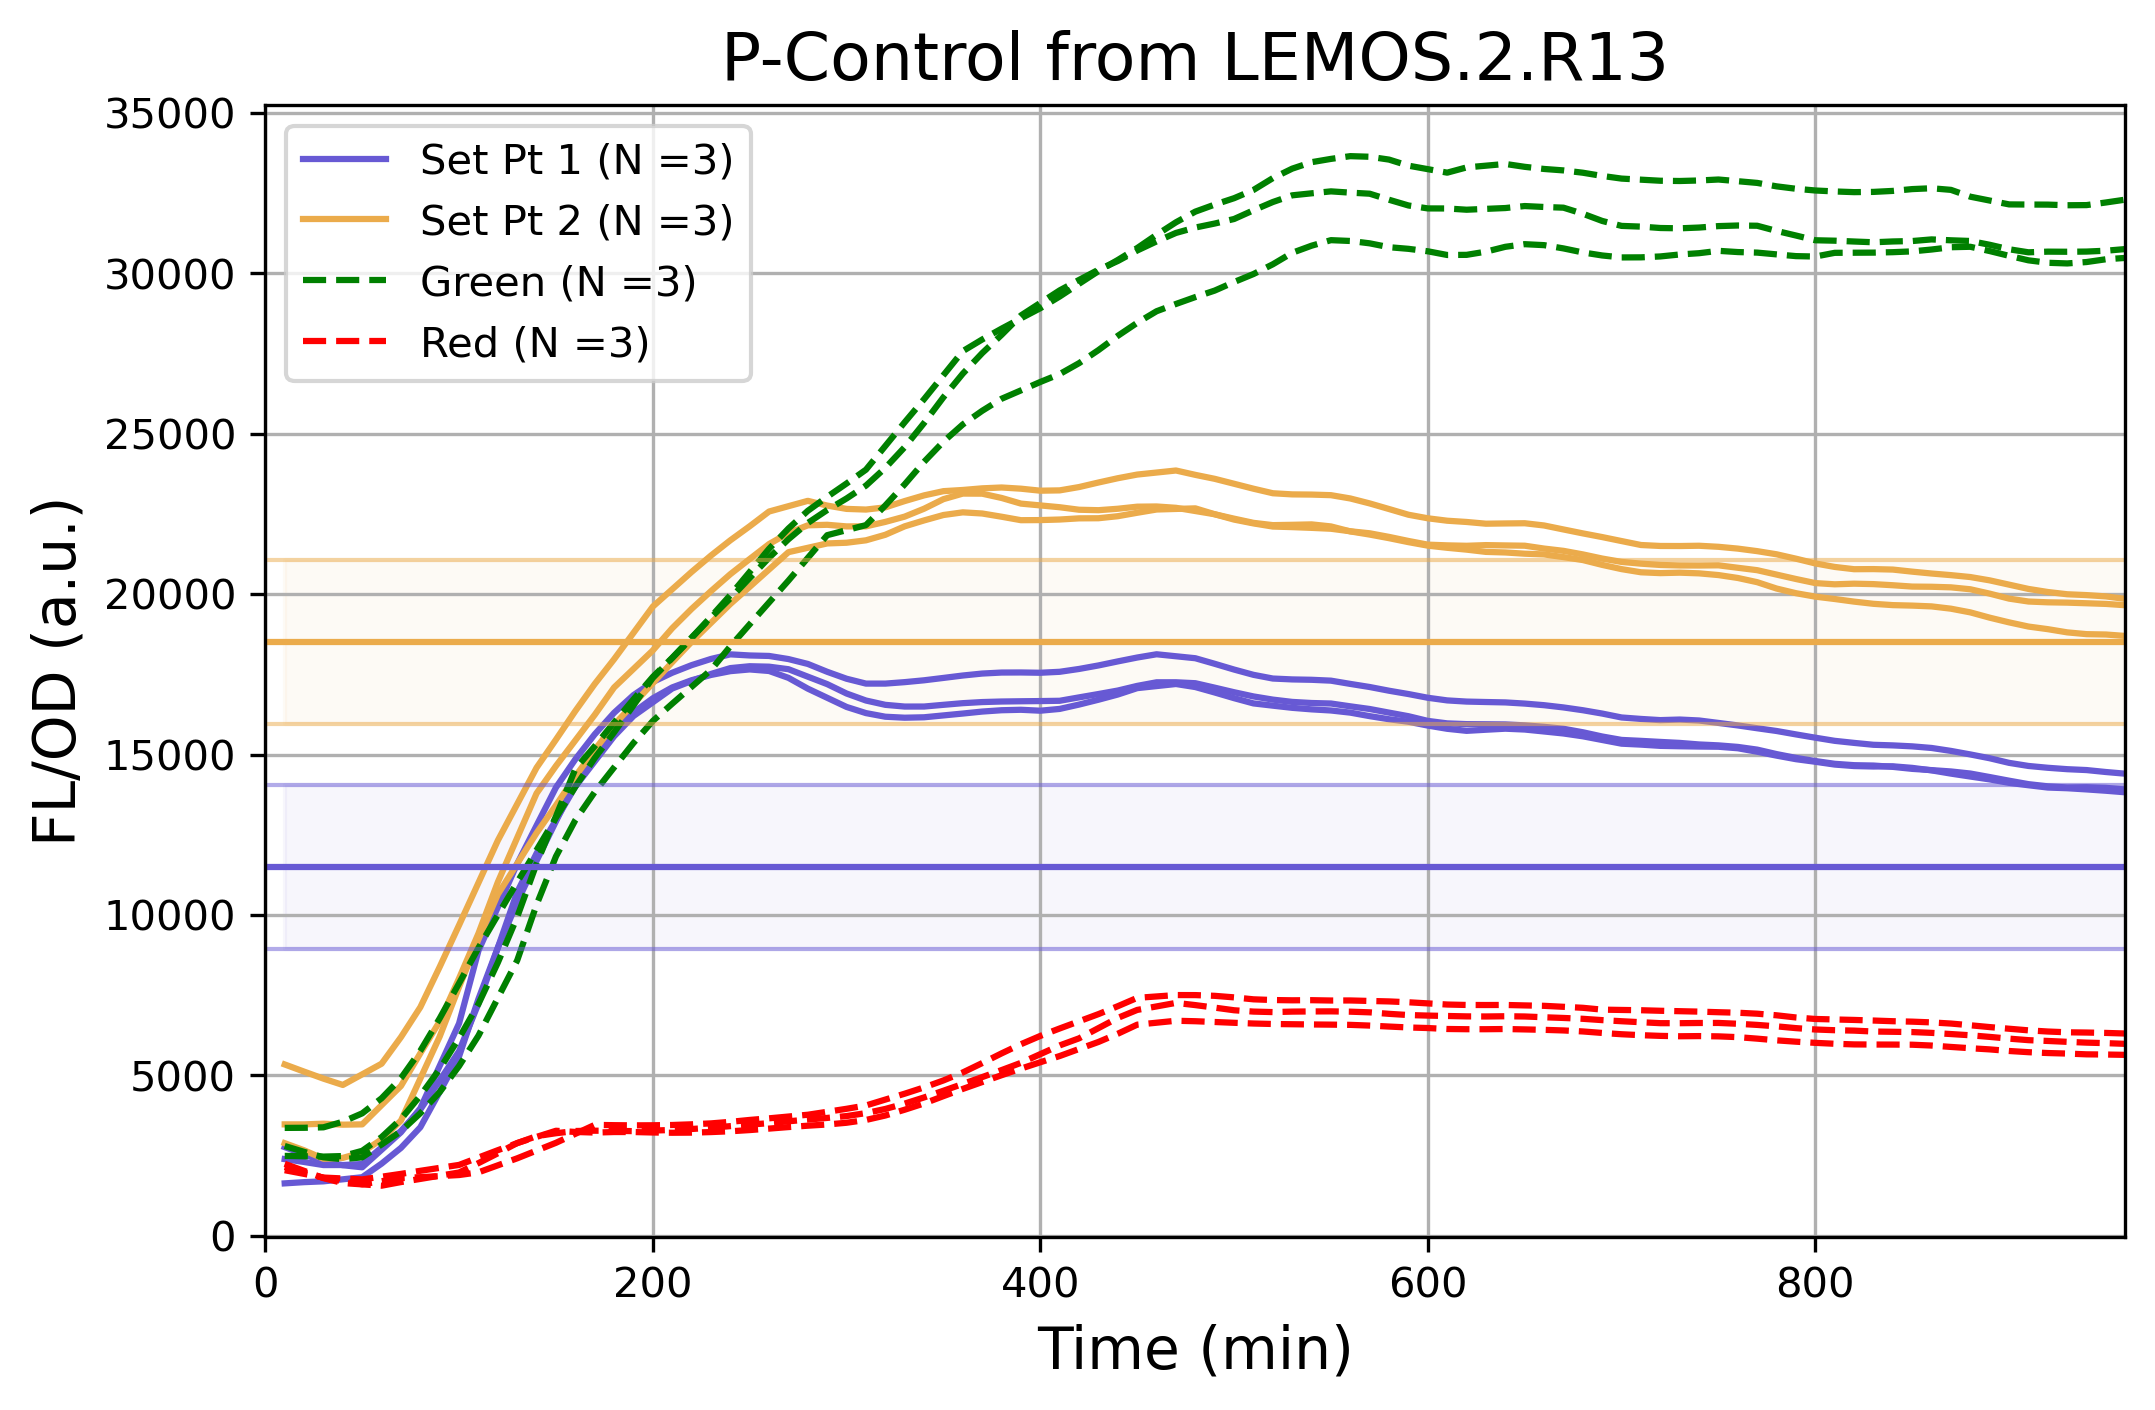

In [11]:
# Figure 2: Dataset 0401025
plot_replicates(time2, P1_data2, P2_data2, green_data2, red_data2, 'P-Control from LEMOS.2.R13')

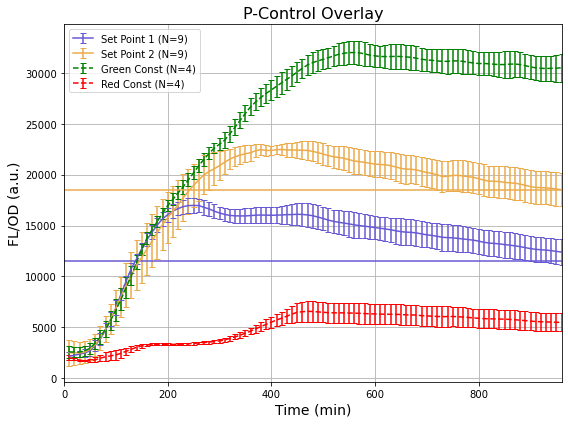

In [12]:
# Figure 3: Combined averages ± standard deviation
fig, ax = plt.subplots(figsize=(8,6))

capsz = 3  # Error bar cap size

ax.errorbar(time1, P1_mean, yerr=P1_std, color=color_dict['set_point_1'], label='Set Point 1 (N=9)', capsize=capsz)
ax.errorbar(time2, P2_mean, yerr=P2_std, color=color_dict['set_point_2'], label='Set Point 2 (N=9)', capsize=capsz)
ax.errorbar(time1, green_mean, yerr=green_std, color=color_dict['green_constant'], linestyle='--', label='Green Const (N=4)', capsize=capsz)
ax.errorbar(time1, red_mean, yerr=red_std, color=color_dict['red_constant'], linestyle='--', label='Red Const (N=4)', capsize=capsz)

# Draw horizontal lines at correct setpoints
ax.axhline(y=st_pt_1, color=color_dict['set_point_1'])
ax.axhline(y=st_pt_2, color=color_dict['set_point_2'])

ax.set_xlabel('Time (min)', fontsize=14)
ax.set_ylabel('FL/OD (a.u.)', fontsize=14)
ax.set_title('P-Control Overlay', fontsize=16)
ax.legend()
ax.grid(True)
ax.set_xlim((0, xlimit))

plt.tight_layout()
plt.show()

In [19]:
# === Performance analysis for each replicate individually ===

# Time and signal arrays
N_size = 104
interval = 10 # min
time = range(interval, (N_size + 1) * interval, interval)
time_array = np.array(time)
signal_1 = P1_mean
signal_2 = P2_mean

# Final values (assumed steady-state)
final_value_1 = st_pt_1
final_value_2 = st_pt_2

def compute_settling_time(signal, time, final_value, tol, cap=960):
        """
        Settling time = earliest time t_k such that signal[t_k:] is entirely within
        [final_value - tol, final_value + tol]. If none, return cap.

        Parameters
        ----------
        signal : 1D np.array
        time   : 1D np.array (same length as signal)
        final_value : float (the setpoint)
        tol    : float (half-width of tolerance band around setpoint)
        cap    : float (returned if never persistently inside band)

        Returns
        -------
        float : settling time in same units as `time`
        """
        lower = final_value - tol
        upper = final_value + tol

        inside = (signal >= lower) & (signal <= upper)               # boolean vector
        # suffix_all[i] == True  <=> inside[i:] are all True
        suffix_all = np.flip(np.cumprod(np.flip(inside.astype(int))).astype(bool))

        idx_candidates = np.where(suffix_all)[0]
        if idx_candidates.size == 0:
            return cap
        return float(time[idx_candidates[0]])

def analyze_replicate(signal, time, final_value, tolerance_band, replicate_label):
    # Rise Time
    start_idx = np.where(signal >= 0 * final_value)[0]
    end_idx = np.where(signal >= final_value - tolerance_band)[0]
    rise_time = time[end_idx[0]] - time[start_idx[0]] if len(start_idx) > 0 and len(end_idx) > 0 else None

    settling_time = compute_settling_time(signal, time, final_value, tolerance_band)

    if settling_time is not None and rise_time is not None:
        t_settle = settling_time - rise_time
    else:
        t_settle = None

    print(f"{replicate_label} - Rise Time: {rise_time}, Settling Time: {settling_time}, t_settle: {t_settle}")
    return rise_time, settling_time, t_settle


# === Loop through each replicate for SP1 and SP2 and save metrics ===
tolerance_band = 0.1 * (np.max(green_mean - red_mean))  # 10% tolerance band

replicate_metrics = []

print("\n=== Replicate-wise Metrics for SP1 ===")
for i in range(P1_combined.shape[1]):
    signal = P1_combined[:, i]
    rise, settle, t_settle = analyze_replicate(signal, time_array, final_value_1, tolerance_band, f'SP1 Replicate {i+1}')
    replicate_metrics.append({
        'Set Point': 'SP1',
        'Replicate': i+1,
        'Rise Time': rise,
        'Settling Time': settle,
        't_settle': t_settle
    })

print("\n=== Replicate-wise Metrics for SP2 ===")
for i in range(P2_combined.shape[1]):
    signal = P2_combined[:, i]
    rise, settle, t_settle = analyze_replicate(signal, time_array, final_value_2, tolerance_band, f'SP2 Replicate {i+1}')
    replicate_metrics.append({
        'Set Point': 'SP2',
        'Replicate': i+1,
        'Rise Time': rise,
        'Settling Time': settle,
        't_settle': t_settle
    })

# === Compute offset error for each replicate ===
# Formula: (max_value - set_point) / (max_dynamic_range) * 100
# max_dynamic_range = np.max(green_mean - red_mean)
max_dynamic_range = np.max(green_mean - red_mean)

for i in range(P1_combined.shape[1]):
    signal = P1_combined[:, i]
    max_value = np.max(signal)
    offset_error = (max_value - final_value_1) / max_dynamic_range * 100
    replicate_metrics[i]['Offset Error'] = offset_error

for i in range(P2_combined.shape[1]):
    signal = P2_combined[:, i]
    max_value = np.max(signal)
    offset_error = (max_value - final_value_2) / max_dynamic_range * 100
    replicate_metrics[i + P1_combined.shape[1]]['Offset Error'] = offset_error

# Convert to DataFrame
metrics_df = pd.DataFrame(replicate_metrics)

# Save to CSV
metrics_df.to_csv('P_replicate_metrics_10_tol_band.csv', index=False)

# Optional: Print the full DataFrame for clarity
print("\n=== Summary Table ===")
print(metrics_df)



=== Replicate-wise Metrics for SP1 ===
SP1 Replicate 1 - Rise Time: 100, Settling Time: 600.0, t_settle: 500.0
SP1 Replicate 2 - Rise Time: 110, Settling Time: 700.0, t_settle: 590.0
SP1 Replicate 3 - Rise Time: 110, Settling Time: 670.0, t_settle: 560.0
SP1 Replicate 4 - Rise Time: 110, Settling Time: 530.0, t_settle: 420.0
SP1 Replicate 5 - Rise Time: 110, Settling Time: 500.0, t_settle: 390.0
SP1 Replicate 6 - Rise Time: 110, Settling Time: 640.0, t_settle: 530.0
SP1 Replicate 7 - Rise Time: 110, Settling Time: 1000.0, t_settle: 890.0
SP1 Replicate 8 - Rise Time: 110, Settling Time: 910.0, t_settle: 800.0
SP1 Replicate 9 - Rise Time: 110, Settling Time: 920.0, t_settle: 810.0

=== Replicate-wise Metrics for SP2 ===
SP2 Replicate 1 - Rise Time: 260, Settling Time: 960, t_settle: 700
SP2 Replicate 2 - Rise Time: 200, Settling Time: 530.0, t_settle: 330.0
SP2 Replicate 3 - Rise Time: 190, Settling Time: 560.0, t_settle: 370.0
SP2 Replicate 4 - Rise Time: 210, Settling Time: 460.0, t_s